# Depth estimation of detected trees in panoramic imagery using MonoDepth




In [5]:
# Guide on Prediction with Yolo Model: https://docs.ultralytics.com/yolov5/tutorials/pytorch_hub_model_loading/#before-you-start

# Import Libraries

import torch
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
import PIL.Image as pil
import os
import shutil
import numpy as np
import pandas as pd
import cv2
import random
import json
import sys
import math
import geopy

# Notebook and Vis Params
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Apply Yolo and MonoDepth Estimates to Geolocate Trees

In [7]:
import os
import pandas as pd
import json
import torch
import sys
from skimage.io import imread
from PIL import Image as pil
from torchvision import transforms
import numpy as np
from math import asin, atan2, cos, degrees, radians, sin
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Make sure the path to the monodepth2 repository is correct
sys.path.insert(1, 'C:/users/talake2/Desktop/')
sys.path.insert(1, 'C:/users/talake2/Desktop/monodepth2/')

# Import necessary modules from monodepth2
from monodepth2 import networks
from monodepth2.utils import download_model_if_doesnt_exist
from monodepth2 import layers

##### LOAD HELPER FUNCTIONS #####

def calculate_rotation(row, img_width, pano_rotation_north):
    """
    Calculate the angle of rotation of a tree in the panoramic image, based on the 
    vertical center of the bounding box given the 360-degree image.
    """
    # Extract vertical center of the tree bounding box
    tree_center_x = (row['xmin'] + row['xmax']) / 2

    # Calculate the angle relative to the north
    px_per_degree = (img_width/360) # eq. 45.5111
    
    tree_angle = tree_center_x / px_per_degree

    # Adjust the angle based on the north rotation value
    adjusted_angle = (tree_angle - pano_rotation_north) % 360

    return adjusted_angle

def crop_image(img, xmin, ymin, xmax, ymax):
    """
    Crop the input image based on bounding box coordinates.

    Parameters:
    - img: Input image (numpy array).
    - xmin, ymin, xmax, ymax: Bounding box coordinates.

    Returns:
    - Cropped image.
    """
    cropped_img = img[ymin:ymax, xmin:xmax, :]
    return cropped_img

def get_point_at_distance(lat1, lon1, d, bearing, R=6371):
    """
    lat: initial latitude, in degrees
    lon: initial longitude, in degrees
    d: target distance from initial
    bearing: (true) heading in degrees
    R: optional radius of sphere, defaults to mean radius of earth

    Returns new lat/lon coordinate {d}km from initial, in degrees
    Source: https://stackoverflow.com/questions/7222382/get-lat-long-given-current-point-distance-and-bearing
    """
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    a = radians(bearing)
    d = d/1000 # Convert from Km to meters
    lat2 = asin(sin(lat1) * cos(d/R) + cos(lat1) * sin(d/R) * cos(a))
    lon2 = lon1 + atan2(
        sin(a) * sin(d/R) * cos(lat1),
        cos(d/R) - sin(lat1) * sin(lat2)
    )
    return (degrees(lat2), degrees(lon2),)

def disp_to_depth(disp, min_depth, max_depth):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth



# Define the pandas dataframe to old trees information
trees_df = pd.DataFrame(columns=["pano_ID", "pano_rotation", "pano_lat", "pano_lon",
                                 "tree_id", "tree_rotation_value", "tree_depth",
                                 "tree_lat", "tree_lon"])

img_folder = r'C:\Users\talake2\Desktop\boulder_pano_testing' # Define img_folder path

##### LOAD YOLO Model #####

# Load a pretrained YOLO model that detects trees
model1_name = 'yolov5x-oct2323-autoarborist-25epochs'
model1_path = f'C:/Users/talake2/Desktop/auto_arborist_cvpr2022_v015/yolov5/runs/train/{model1_name}/weights/last.pt'
tree_model = torch.hub.load(r'C:/Users/talake2/Desktop/auto_arborist_cvpr2022_v015/yolov5', 'custom', path=model1_path, source='local')

##### LOAD MONODEPTH2 Model #####

STEREO_SCALE_FACTOR = 1.5
# https://github.com/nianticlabs/monodepth2/blob/master/evaluate_depth.py
# Models which were trained with stereo supervision were trained with a nominal
# baseline of 0.1 units. The KITTI rig has a baseline of 54cm. Therefore,
# to convert our stereo predictions to real-world scale we multiply our depths by 5.4.

# Load a pretrained MonoDepth model that estimates disparity/depth
encoder_path = "C:/users/talake2/Desktop/monodepth2/models/mono+stereo_1024x320/encoder.pth"
depth_decoder_path = "C:/users/talake2/Desktop/monodepth2/models/mono+stereo_1024x320/depth.pth"

# loading pretrained MonoDepth2 model
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval()


##### PERFORM GEOLOCATION #####

# Iterate over each image in the directory.
for img_name in os.listdir(img_folder):
    # Read in directory of panoramic images, and metadata.json files
    if img_name.endswith('.jpg'): 
        img_path = os.path.join(img_folder, img_name)
        json_path = img_path.replace('.jpg', '.metadata.json')

        with open(json_path, 'r') as json_file:
            img_metadata = json.load(json_file)

        # Get metadata for panorama print(img_metadata)
        pano_id = img_metadata['panoId']
        pano_rotation_value = img_metadata['rotation'] # North
        pano_lat = img_metadata['lat']
        pano_lon = img_metadata['lng']
        
        print(f'Processing: ', pano_id)

        # Read panoramic image and use YOLO model to detect trees
        img = imread(img_path)
        model_results = tree_model(img) # Run YOLO Inference
        model_results_df = model_results.pandas().xyxy[0] # Store YOLO results
       
        # Estimate depth in panoramic image with MonoDepth2
        input_image = pil.open(img_path).convert('RGB')
        original_width, original_height = input_image.size
        feed_height = loaded_dict_enc['height']
        feed_width = loaded_dict_enc['width']
        input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

        input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

        # Run MonoDepth2 to estimate disparity 
        with torch.no_grad():
            features = encoder(input_image_pytorch)
            outputs = depth_decoder(features)

        # Convert disparity to depth (meters) from MonoDepth2
        disp = outputs[("disp", 0)]
        disp_resized = torch.nn.functional.interpolate(disp, (original_height, original_width), mode="bilinear", align_corners=False)
        scaled_disp, depth = disp_to_depth(disp_resized, 0.1, 100)

        # Multiply disparity by scaling factor to output depth (meters)
        # See: https://github.com/nianticlabs/monodepth2/issues/295
        metric_depth = STEREO_SCALE_FACTOR * depth.squeeze().cpu().numpy()
        metric_depth_resized = metric_depth[:, :, np.newaxis] # Expand dim to: 8192, 16384, 1

        # Geolocate each detected tree
        for index, row in model_results_df.iterrows():
            
            # Get index and rotation (0-360 degrees) for detected tree in the panoramic image
            tree_id = index
            tree_rotation_value = calculate_rotation(row, original_width, pano_rotation_value)

            # Get bounding box for detected tree in the panoramic image
            xmin, ymin, xmax, ymax = (
                int(row['xmin']),
                int(row['ymin']),
                int(row['xmax']),
                int(row['ymax'])
            )
                        
            # Crop the depth map to the tree detected in the panoramic image
            cropped_depth = crop_image(metric_depth_resized, xmin, ymin, xmax, ymax)

            # Estimate depth at the mid-point of the detected tree bounding box
            tree_depth = cropped_depth[cropped_depth.shape[0] // 2, cropped_depth.shape[1] // 2].item()
            
            # Following Lumnitz et al., 2021. Only use estimated tree depth < 15 meters. 
            if tree_depth < 15:

                # Geolocate tree given pano origin, distance, and bearing
                tree_lat, tree_lon = get_point_at_distance(pano_lat, pano_lon, tree_depth, tree_rotation_value)

                # Create a temporary DataFrame for the new row
                temp_df = pd.DataFrame([[pano_id, pano_rotation_value, pano_lat, pano_lon, tree_id, 
                                         tree_rotation_value, tree_depth, tree_lat, tree_lon]], 
                                        columns=trees_df.columns)

                # Append the row to the DataFrame
                trees_df = pd.concat([trees_df, temp_df], ignore_index=True)
            


YOLOv5  v7.0-226-gdd9e338 Python-3.10.13 torch-2.1.2 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)

Fusing layers... 
autoarborist_architecture_YOLOv5x summary: 322 layers, 86173414 parameters, 0 gradients, 203.8 GFLOPs
Adding AutoShape... 


<All keys matched successfully>

<All keys matched successfully>

ResnetEncoder(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

DepthDecoder(
  (decoder): ModuleList(
    (0-1): 2 x ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (2-3): 2 x ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (4-5): 2 x ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (6): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (7): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1)

C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing:  ZnsB5RhFImasUBuO2QlFIA


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing:  OcSMnPhlXsZr-y0lBLANhg


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing:  GdJI6LH7BY4HFHfcxY0Bpw


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing:  JLsJxj3U4ew1PfflntA2LA


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing:  KgnVovgvuipNorDeYbBozg


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing:  BnaHGXS3kmIUggZysnq8cQ


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing:  -Q-1snsVbGdIZ5GcYnyLIg


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing:  pRTBBCKtz3jjFaKHa106xQ


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing:  v08oZ91eq1e7olLT3tzGQQ


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing:  ydU6po35gza8Rc7NfO5z9A


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing:  TUt4IKErE5FBoByPZvTytg


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing:  b2Ir5pfirza4T3-wawR9Og


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing:  QwWqEM18gOGU3O_akOkSpw


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing:  KxmSypwTUb-xUoVmeMMFvA


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing:  ynC09ZHYd11TM15F43TZww


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing:  CQD2jN_MqIV7yAf9FeQZig


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing:  QBZoFhxz06M4am6LPhvGQg


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing:  _qrB4nYEew5Fdn83eXGI-Q


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing:  o7IRqLh-Rw6OjChYrkBjeg


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


# Visualize Predicted Tree Locations and Ground Truth

In [3]:
trees_df

,pano_ID,pano_rotation,pano_lat,pano_lon,tree_id,tree_rotation_value,tree_depth,tree_lat,tree_lon
0,ZnsB5RhFImasUBuO2QlFIA,311.568268,40.035702,-105.226304,0,140.522176,8.666491,40.035642,-105.226239
1,ZnsB5RhFImasUBuO2QlFIA,311.568268,40.035702,-105.226304,1,88.718154,12.137379,40.035705,-105.226161
2,ZnsB5RhFImasUBuO2QlFIA,311.568268,40.035702,-105.226304,4,330.739939,8.287737,40.035767,-105.226351
3,ZnsB5RhFImasUBuO2QlFIA,311.568268,40.035702,-105.226304,6,112.738428,14.448427,40.035652,-105.226147
4,ZnsB5RhFImasUBuO2QlFIA,311.568268,40.035702,-105.226304,9,15.904380,10.985666,40.035797,-105.226269
...,...,...,...,...,...,...,...,...,...
76,o7IRqLh-Rw6OjChYrkBjeg,311.227524,40.035885,-105.226036,1,325.566587,14.947977,40.035996,-105.226135
77,o7IRqLh-Rw6OjChYrkBjeg,311.227524,40.035885,-105.226036,2,150.073452,8.742475,40.035817,-105.225985
78,o7IRqLh-Rw6OjChYrkBjeg,311.227524,40.035885,-105.226036,4,14.477484,9.262338,40.035966,-105.226009
79,o7IRqLh-Rw6OjChYrkBjeg,311.227524,40.035885,-105.226036,6,255.048082,13.969587,40.035853,-105.226195


Text(0.5, 0, 'Longitude')

Text(0, 0.5, 'Latitude')

Text(0.5, 1.0, 'Predicted Tree Coordinates with Panoramic Locations')

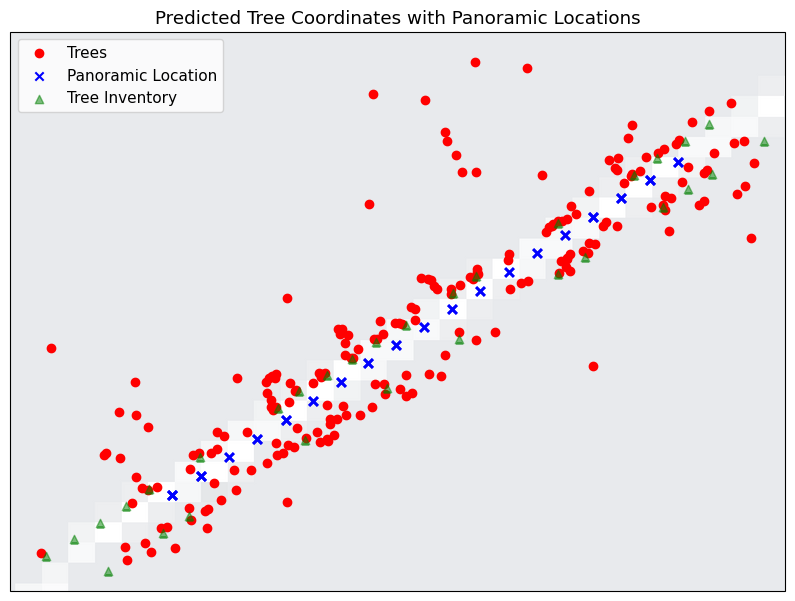

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io import img_tiles
%matplotlib inline


# Define the bounding box for tree predictions
bbox = [
    trees_df['tree_lon'].min() - 0.0001,
    trees_df['tree_lon'].max() + 0.0001,
    trees_df['tree_lat'].min() - 0.0001,
    trees_df['tree_lat'].max() + 0.0001
]

# Read in ground truth .csv file containing 'latitude' and 'longitude' columns information on tree locations
tree_inventory_df = pd.read_csv(r'C:\Users\talake2\Desktop\auto_arborist_cvpr2022_v015\auto_arborist_tfrecords_data\auto_arborist_tfrecords_csv\tfrecords_locs_all.csv')

# Crop the .csv file records to the bounding box where trees are predicted
cropped_tree_inventory = tree_inventory_df[
    (tree_inventory_df['Longitude'] >= bbox[0]) &
    (tree_inventory_df['Longitude'] <= bbox[1]) &
    (tree_inventory_df['Latitude'] >= bbox[2]) &
    (tree_inventory_df['Latitude'] <= bbox[3])
]

# Plotting
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Use Google Maps satellite imagery as the basemap
google_tiles = img_tiles.GoogleTiles()
ax.add_image(google_tiles, 14, interpolation='spline36')

# Plotting tree coordinates
ax.scatter(trees_df['tree_lon'], trees_df['tree_lat'], color='red', marker='o', label='Trees')

# Plotting panoramic location
ax.scatter(trees_df['pano_lon'], trees_df['pano_lat'], color='blue', marker='x', label='Panoramic Location')

# Plotting cropped tree inventory locations as transparent green triangles
ax.scatter(cropped_tree_inventory['Longitude'], cropped_tree_inventory['Latitude'],
           color='green', marker='^', alpha=0.5, label='Tree Inventory')

# Set the extent for zooming in
ax.set_extent(bbox, crs=ccrs.PlateCarree())

# Adding labels and legend
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Predicted Tree Coordinates with Panoramic Locations')
ax.legend()

# Show the plot
plt.show()


# Average Duplicate Observations within Buffer of Tree Inventory

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

# Define the maximum distance for buffering
max_dist = 0.00005 # approx 5.55 meters 0.00005
max_dist = 0.0001

# Create a new dataframe to hold the averaged point locations
averaged_points = []

# Define the bounding box area used for tree predictions
bbox = [
    trees_df['tree_lon'].min() - 0.0001,
    trees_df['tree_lon'].max() + 0.0001,
    trees_df['tree_lat'].min() - 0.0001,
    trees_df['tree_lat'].max() + 0.0001
]

# Read in ground truth .csv file containing 'latitude' and 'longitude' columns information on tree locations
tree_inventory_df = pd.read_csv(r'C:\Users\talake2\Desktop\auto_arborist_cvpr2022_v015\auto_arborist_tfrecords_data\auto_arborist_tfrecords_csv\tfrecords_locs_all.csv')

# Crop the ground truth records to the bounding box where trees are predicted
cropped_tree_inventory = tree_inventory_df[
    (tree_inventory_df['Longitude'] >= bbox[0]) &
    (tree_inventory_df['Longitude'] <= bbox[1]) &
    (tree_inventory_df['Latitude'] >= bbox[2]) &
    (tree_inventory_df['Latitude'] <= bbox[3])
]

# Create a GeoDataFrame for predicted tree locations with buffers
trees_geometry = gpd.points_from_xy(trees_df['tree_lon'], trees_df['tree_lat'])
trees_gdf = gpd.GeoDataFrame(trees_df, geometry=trees_geometry)

# Create a GeoDataFrame for cropped_tree_inventory locations
cropped_tree_inventory_geometry = gpd.points_from_xy(cropped_tree_inventory['Longitude'], cropped_tree_inventory['Latitude'])
cropped_tree_inventory_gdf = gpd.GeoDataFrame(cropped_tree_inventory, geometry=cropped_tree_inventory_geometry)

# Buffer ground truth points and find nearest points in trees_df
buffered_trees_gdf = cropped_tree_inventory_gdf.copy()
buffered_trees_gdf['geometry'] = buffered_trees_gdf['geometry'].buffer(max_dist)

# Initialize a new column to store the average location of trees_df points within the tree inventory buffer
buffered_trees_gdf['average_location'] = None

# Iterate through each ground truth point and find the points in trees_df within the max_dist distance
for idx, row in buffered_trees_gdf.iterrows():
    
    buffer_polygon = row['geometry']
    
    # Find the points in trees_df within the buffer distance
    points_within_buffer = trees_gdf[trees_gdf['geometry'].within(buffer_polygon)]
    
    # Check if there are points within the buffer
    if not points_within_buffer.empty:
        # Calculate the average location of the trees_df points within the buffer
        avg_lon = points_within_buffer['tree_lon'].mean()
        avg_lat = points_within_buffer['tree_lat'].mean()

        # Append the averaged point to the list
        averaged_points.append({'avg_lon': avg_lon, 'avg_lat': avg_lat, 'Tree ID': row['Tree ID']})
        
# Create a DataFrame from the list of averaged points from the tree geolocation estimates
averaged_points_df = pd.DataFrame(averaged_points)

# Create a GeoDataFrame to hold the averaged point locations
averaged_points_geometry = gpd.points_from_xy(averaged_points_df['avg_lon'], averaged_points_df['avg_lat'])
averaged_points_gdf = gpd.GeoDataFrame(averaged_points_df, geometry=averaged_points_geometry)



# Visualilze Predicted Tree Locations, Ground Truth, Buffer Zone, and Averaged Predicted Tree Locations

NameError: name 'cropped_tree_inventory_gdf' is not defined

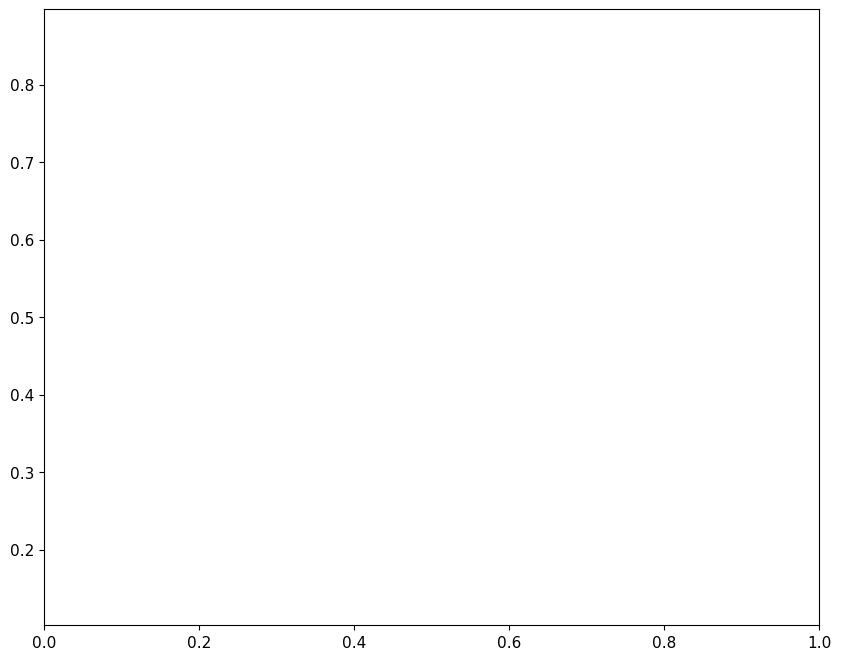

In [9]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_aspect('equal', adjustable='datalim')

# Plot ground truth points and buffer zones
cropped_tree_inventory_gdf.plot(ax=ax, color='red', marker='o', label='Tree Inventory')
buffered_trees_gdf.boundary.plot(ax=ax, color='blue', linewidth=2, linestyle='--', label='Buffer Zone')

# Plot trees_df points and average locations within the buffer
trees_gdf.plot(ax=ax, color='green', marker='o', label='Predicted Trees')
averaged_points_gdf.plot(ax=ax, color='orange', marker='o', label='Average Locations')  # Add this line

# Adding labels and legend
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Ground Truth Points, Buffer Zones, Predicted Trees, and Average Locations')
ax.legend()

# Show the plot
plt.show()

# Error Assessment: Calculate Distance Between Tree Inventory and Detected Trees

In [ ]:
# Error Assessment: Calculate Distance Between Tree Inventory and Detected Trees
from geopy.distance import geodesic

# Cobmine dataframes: tree inventory ground truth dataframe with the averaged estimates for geolocated trees
merged_df = pd.merge(cropped_tree_inventory_gdf, averaged_points_gdf, how='inner', on='Tree ID')  # Replace 'common_identifier' with the actual common identifier or index

# Iterate through each row in the dataframe
for index, row in merged_df.iterrows():
    # Extract latitude and longitude for each point
    point_x = (row['geometry_x'].y, row['geometry_x'].x)
    point_y = (row['geometry_y'].y, row['geometry_y'].x)

    # Calculate the distance between the two points using geodesic
    distance = geopy.distance.geodesic(point_x, point_y).meters

    # Assign the distance to a new column, e.g., 'distance'
    merged_df.at[index, 'Error distance'] = distance

    
# Calculate the RMSE
rmse = np.sqrt((merged_df['Error distance']**2).mean())

print(f'Root Mean Squared Error (RMSE): {rmse:.6f} meters')


In [ ]:
# Assuming 'tree_id' is the common identifier between the DataFrames
merged_df

In [ ]:
trees_df

In [ ]:
# Export Predicted Tree Locations

# Rename columns
merged_df = merged_df.rename(columns={
    'Tree ID': 'tree_id',
    'Tree Location IDX': 'tree_location_idx',
    'City': 'city',
    'Latitude': 'latitude_inventory',
    'Longitude': 'longitude_inventory',
    'Tree Center Y Street Img': 'tree_center_y_street_img',
    'avg_lon': 'longitude_geolocated',
    'avg_lat': 'latitude_geolocated',
    'distance': 'distance'
})

# Export the DataFrame with the updated column names
merged_df.to_csv('c:/users/talake2/desktop/exported_data_la.csv', index=False)

# Visualize Each Detected Tree Per Pano

<Figure size 1000x800 with 0 Axes>

<AxesSubplot:xlabel='tree_lon', ylabel='tree_lat'>

<AxesSubplot:xlabel='tree_lon', ylabel='tree_lat'>

<AxesSubplot:xlabel='tree_lon', ylabel='tree_lat'>

<AxesSubplot:xlabel='tree_lon', ylabel='tree_lat'>

<AxesSubplot:xlabel='tree_lon', ylabel='tree_lat'>

<AxesSubplot:xlabel='tree_lon', ylabel='tree_lat'>

<AxesSubplot:xlabel='tree_lon', ylabel='tree_lat'>

<AxesSubplot:xlabel='tree_lon', ylabel='tree_lat'>

<AxesSubplot:xlabel='tree_lon', ylabel='tree_lat'>

<AxesSubplot:xlabel='tree_lon', ylabel='tree_lat'>

<AxesSubplot:xlabel='tree_lon', ylabel='tree_lat'>

<AxesSubplot:xlabel='tree_lon', ylabel='tree_lat'>

<AxesSubplot:xlabel='tree_lon', ylabel='tree_lat'>

<AxesSubplot:xlabel='tree_lon', ylabel='tree_lat'>

<AxesSubplot:xlabel='tree_lon', ylabel='tree_lat'>

<AxesSubplot:xlabel='tree_lon', ylabel='tree_lat'>

<AxesSubplot:xlabel='tree_lon', ylabel='tree_lat'>

<AxesSubplot:xlabel='tree_lon', ylabel='tree_lat'>

<AxesSubplot:xlabel='tree_lon', ylabel='tree_lat'>

Text(0.5, 0, 'Longitude')

Text(0, 0.5, 'Latitude')

Text(0.5, 1.0, 'Scatterplot of Panoramic Locations and Trees with Matching Colors')

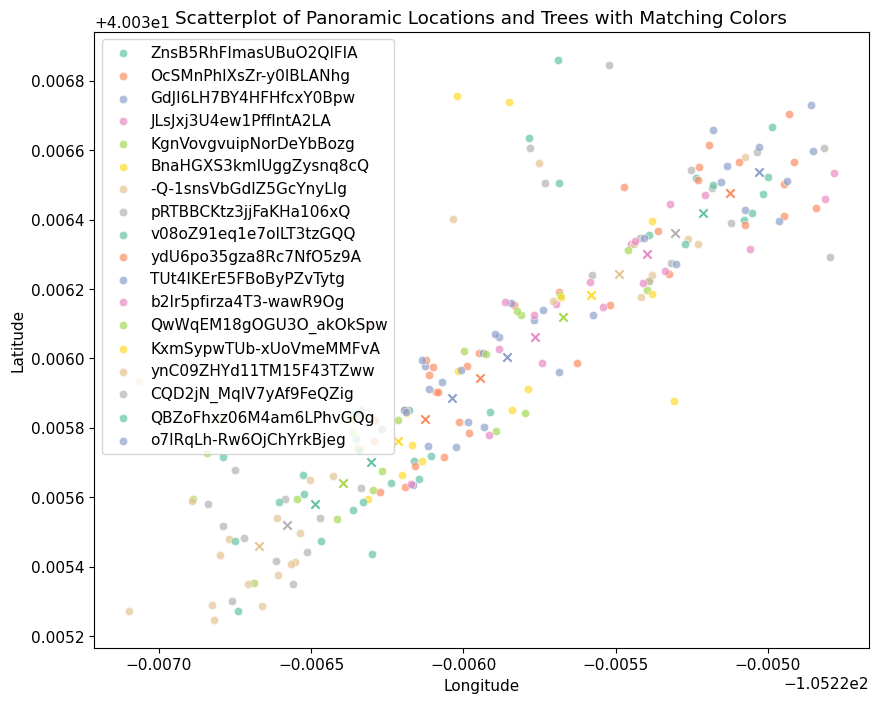

In [10]:
import seaborn as sns

# Make a scatterplot
plt.figure(figsize=(10, 8))

# Define a color palette with unique colors for each pano_ID
color_palette = sns.color_palette("Set2", len(trees_df['pano_ID'].unique()))

# Loop through unique pano_IDs and plot tree coordinates with the same color for both scatterplots
for idx, pano_id in enumerate(trees_df['pano_ID'].unique()):
    subset = trees_df[trees_df['pano_ID'] == pano_id]
    
    # Get the color from the color palette
    color = color_palette[idx]

    sns.scatterplot(x='tree_lon', y='tree_lat', data=subset, label=pano_id, alpha=0.7, color=color)

    # Plot 'X' marker with the same color as the tree data
    pano_data = subset.iloc[0]
    plt.scatter(pano_data['pano_lon'], pano_data['pano_lat'], marker='x', color=color)

# Adding labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatterplot of Panoramic Locations and Trees with Matching Colors')
plt.legend()

# Show the plot
plt.show()